In [ ]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Model # for creating assembling a Neural Network model
from keras import Input # for instantiating a keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
import tensorflow as tf
from keras import backend as K # for access to Keras backend for reparameterization and creating custom loss function

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for plotting model loss
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version
import plotly
import plotly.express as px # for data visualization
print('plotly: %s' % plotly.__version__) # print version

# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

Tensorflow/Keras: 2.8.0
numpy: 1.21.6
matplotlib: 3.2.2
graphviz: 0.10.1
plotly: 5.5.0


Shape of X_train:  (60000, 28, 28)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


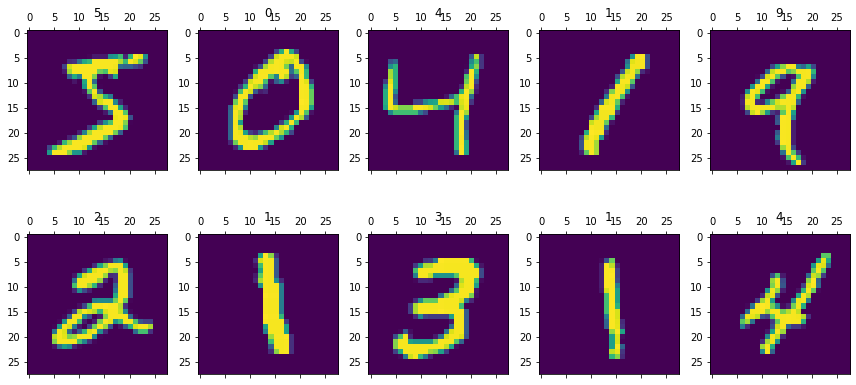

In [ ]:

# Load digits data 
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

# Normalize input data (divide by 255) 
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Display images of the first 10 digits in the training set and their true lables
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title=y_train[n])
        n=n+1
plt.show()

In [ ]:
# Reshape input data
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# Print shapes
print("New shape of X_train: ", X_train.shape)
print("New shape of X_test: ", X_test.shape)

New shape of X_train:  (60000, 784)
New shape of X_test:  (10000, 784)


In [ ]:
#--- Create a function, which we will use to randomly sample from latent space distribution
# Note, epsilon is sampled from a standard normal distribution and is used to maintain the required stochasticity of Z
# Meanwhile, z-mean and z-sigma remain deterministic allowing the loss to backpropagate through the layers.
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

**ENCODER**

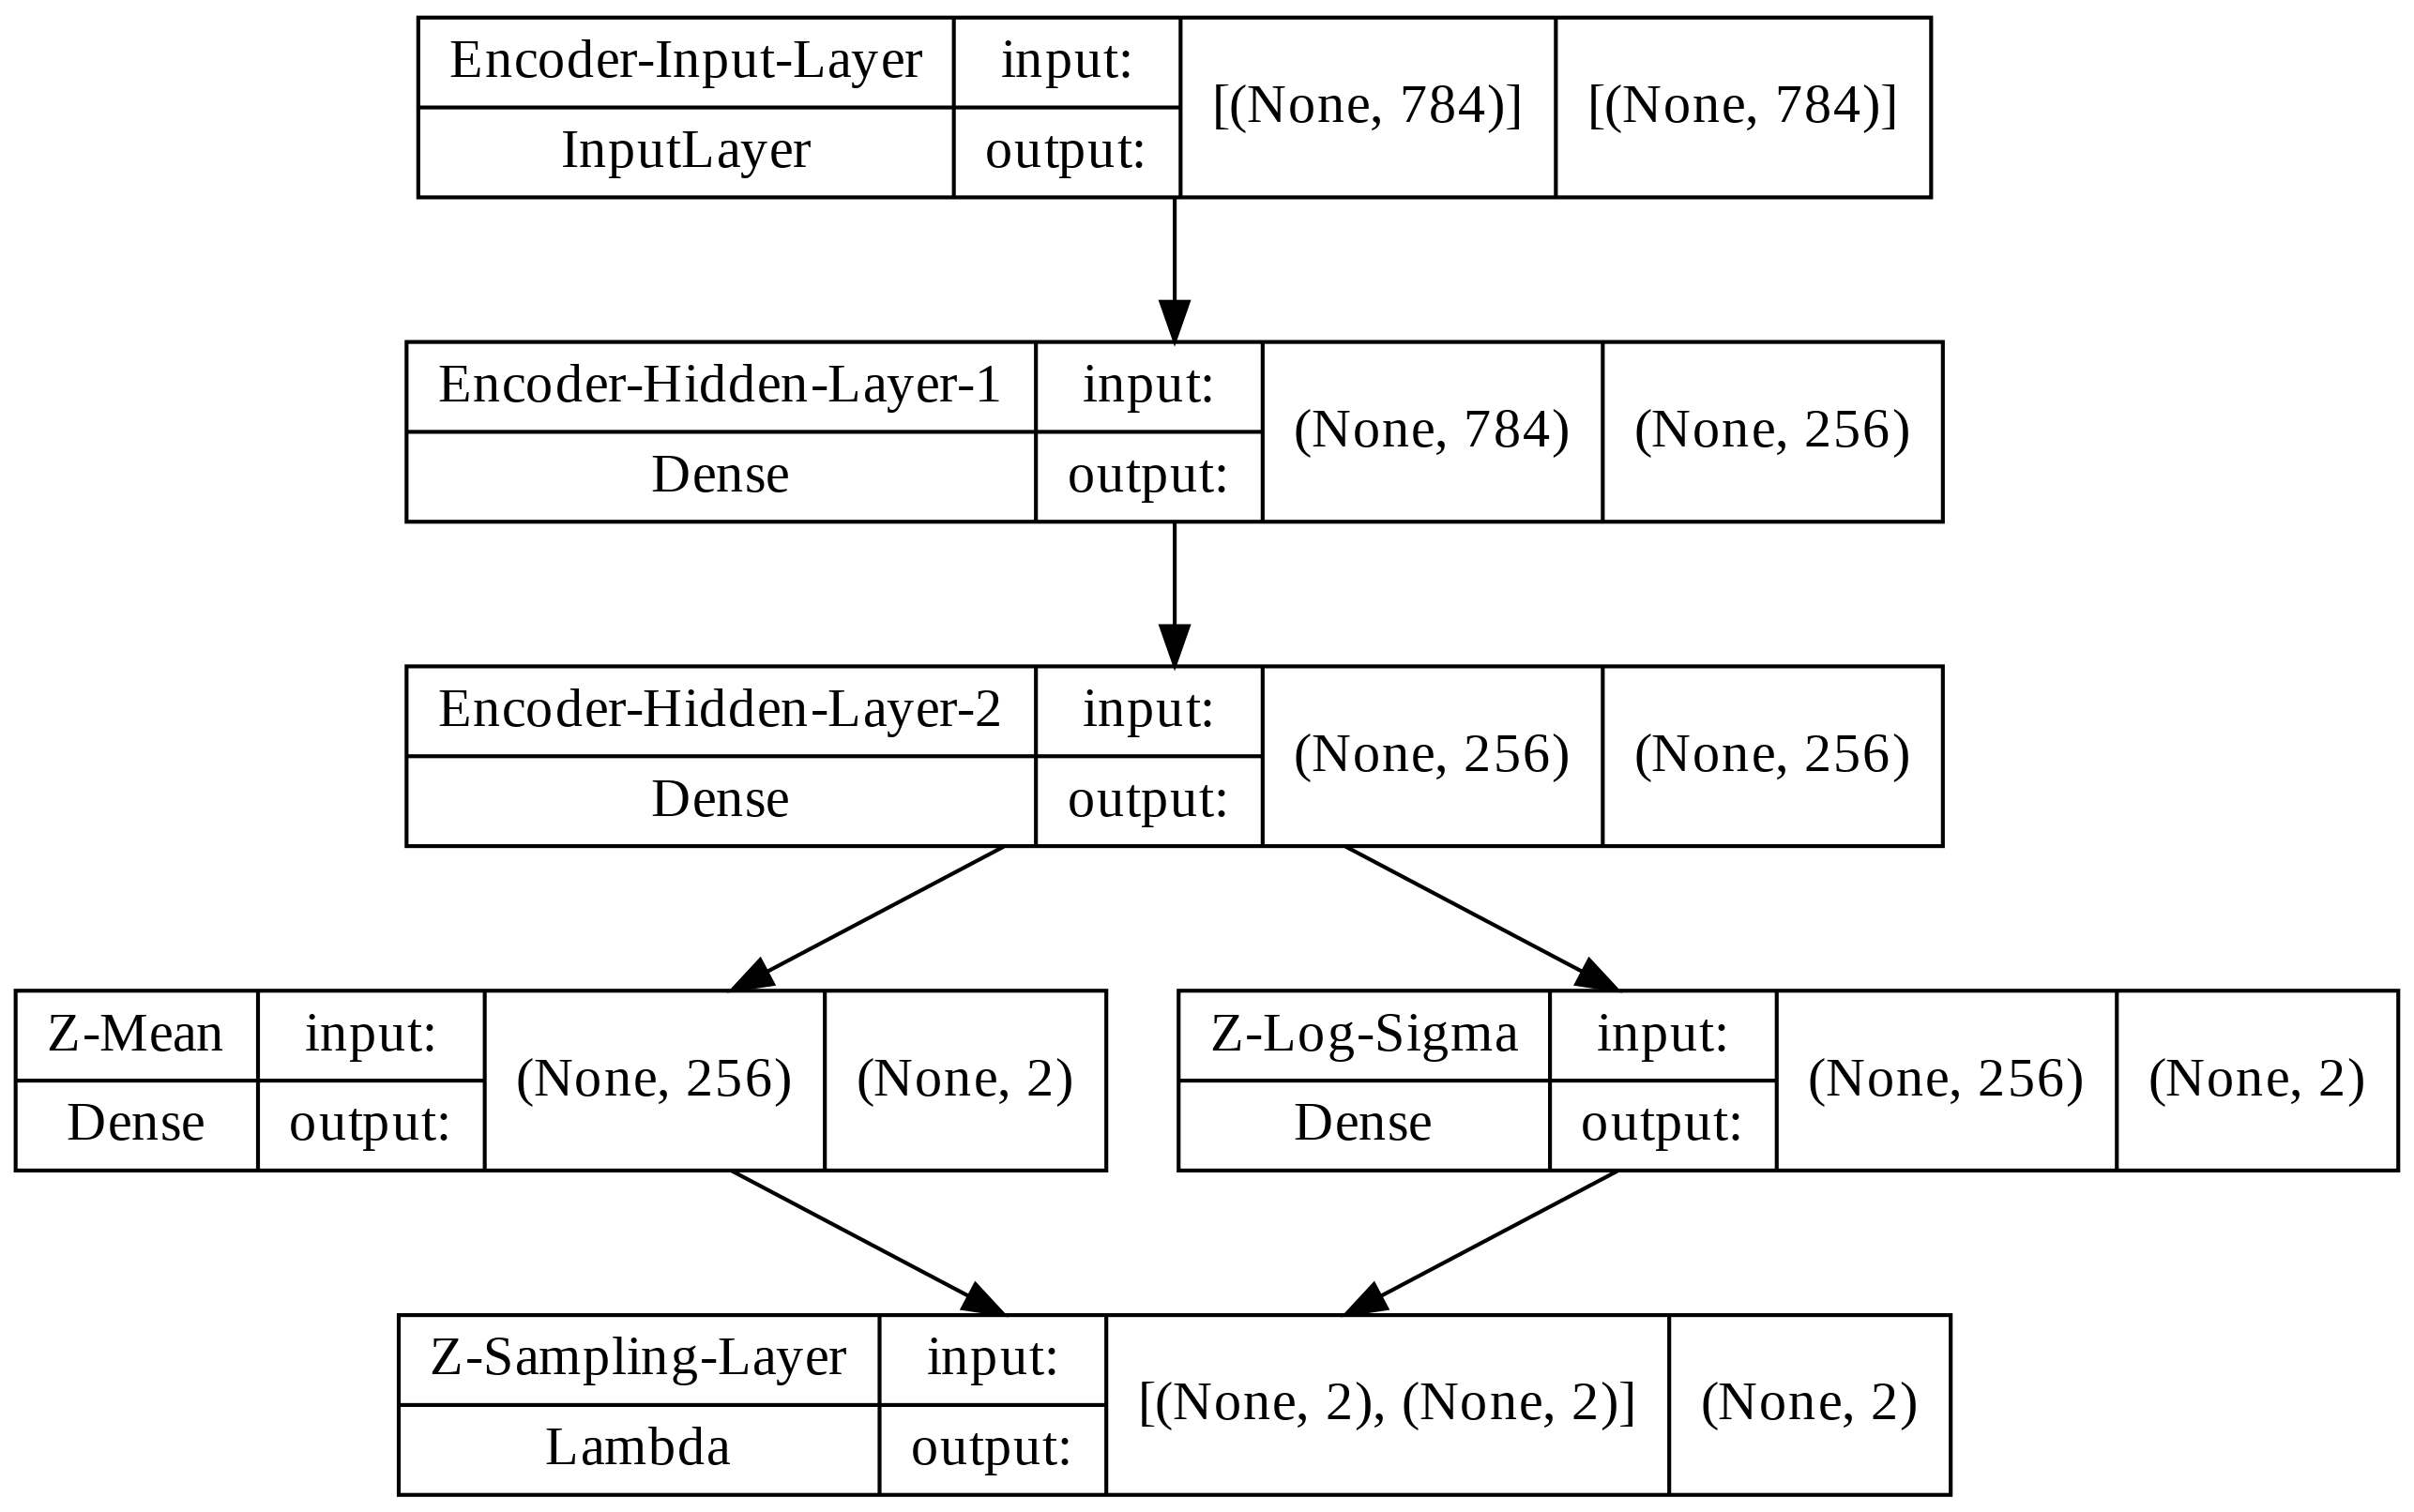

In [ ]:
# Specify dimensions for input/output and latent space layers
original_dim = 784 # number of neurons at the input layer (28 * 28 = 784)
latent_dim = 2 # latent space dimension

# ********** Create Encoder **********

#--- Input Layer 
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

#--- Hidden Layer
h_enc1 = Dense(units=256, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=256, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc2) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc2) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

#--- Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

# Display model diagram
plot_model(encoder, show_shapes=True, dpi=300)

DECODER

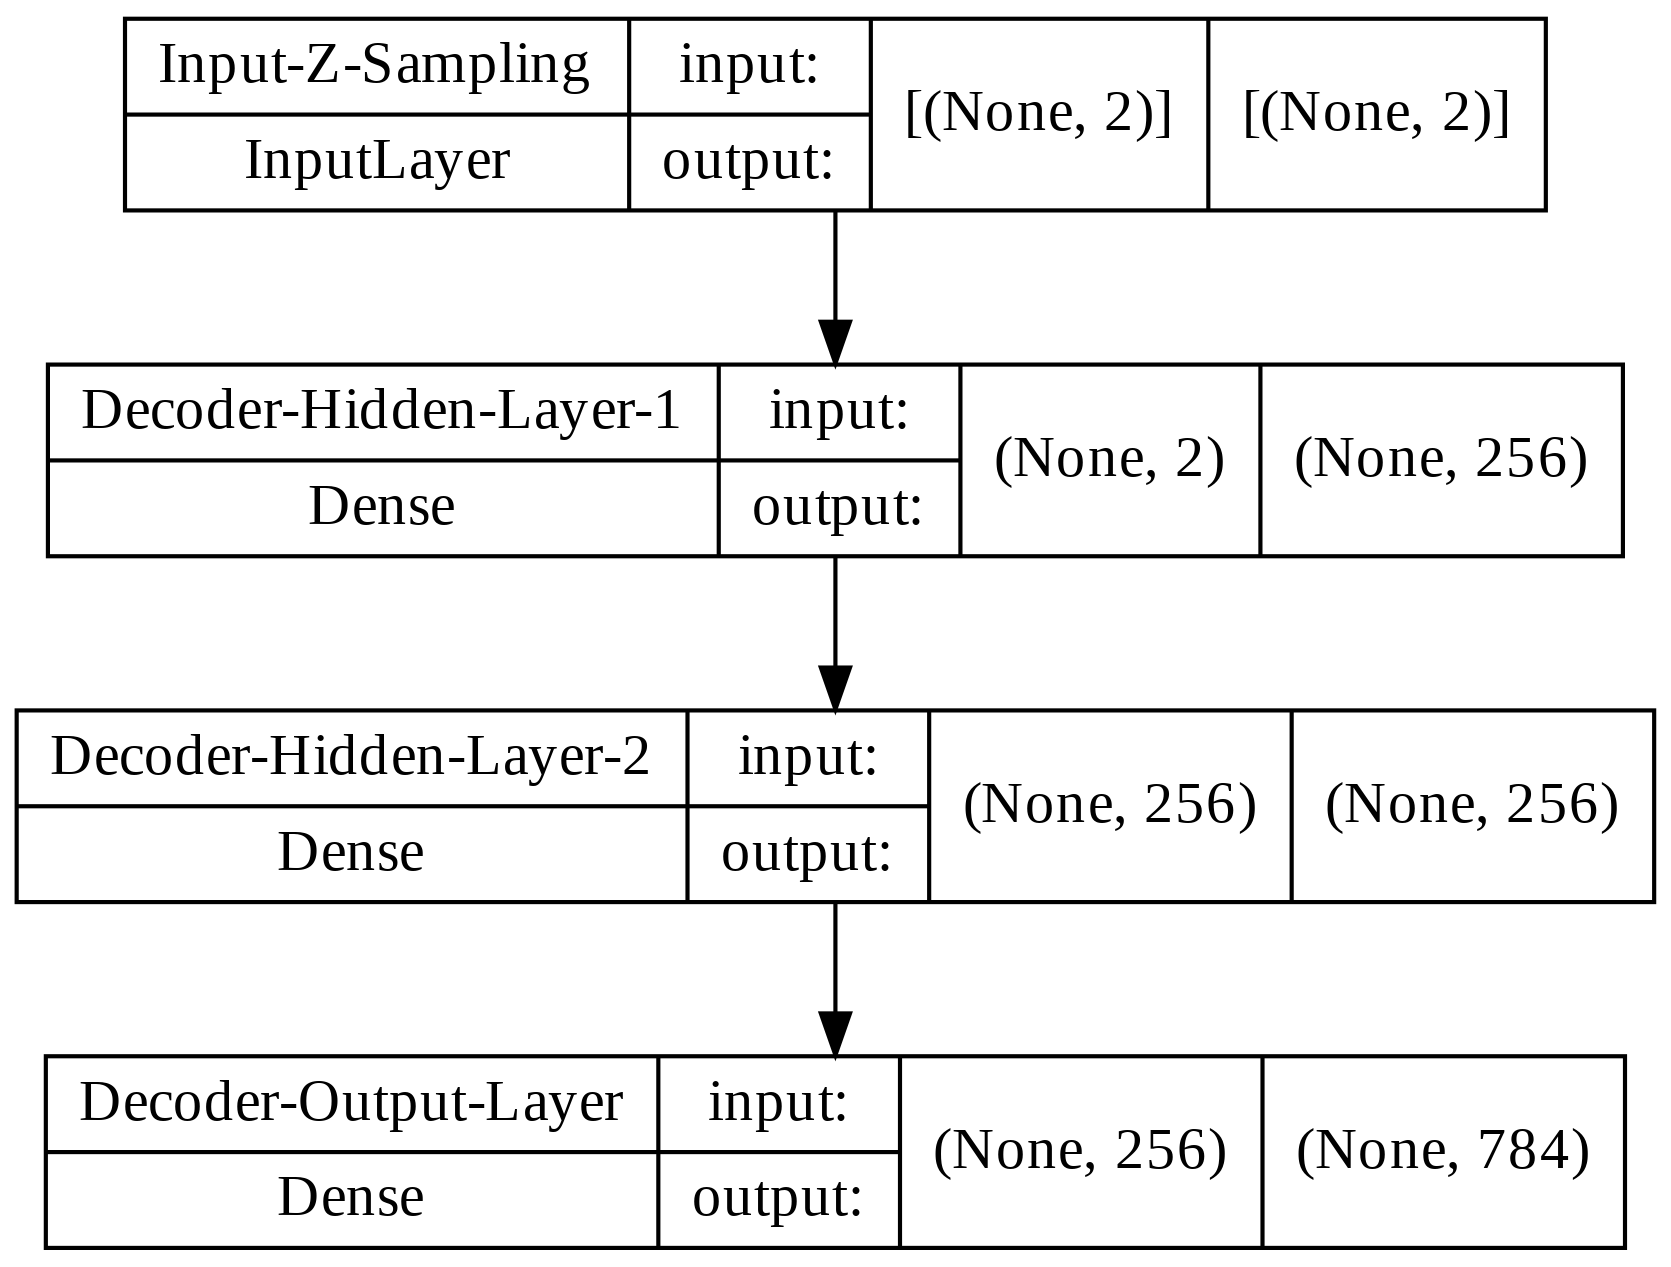

In [ ]:
# ********** Create Decoder **********

#--- Input Layer 
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Hidden Layer
h_dec = Dense(units=256, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=256, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)

#--- Output Layer
outputs = Dense(original_dim, activation='relu', name='Decoder-Output-Layer')(h_dec2)

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

# Display model diagram
plot_model(decoder, show_shapes=True, dpi=300)

In [ ]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')
vae

In [ ]:
# Reconstruction loss compares inputs and outputs and tries to minimise the difference
r_loss = original_dim * keras.losses.mse(visible, outpt)  # use MSE

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add loss to the model and compile it
vae.add_loss(vae_loss)
# vae.compile(optimizer='adam')
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

Epoch 1/100
469/469 [==============================] - 11s 21ms/step - loss: 48.7021 - val_loss: 43.8377
Epoch 2/100
469/469 [==============================] - 10s 20ms/step - loss: 41.8881 - val_loss: 40.9954
Epoch 3/100
469/469 [==============================] - 9s 20ms/step - loss: 40.3825 - val_loss: 39.7514
Epoch 4/100
469/469 [==============================] - 9s 20ms/step - loss: 38.9831 - val_loss: 38.5354
Epoch 5/100
469/469 [==============================] - 9s 20ms/step - loss: 37.9725 - val_loss: 37.6737
Epoch 6/100
469/469 [==============================] - 10s 22ms/step - loss: 37.2908 - val_loss: 37.1344
Epoch 7/100
469/469 [==============================] - 9s 20ms/step - loss: 36.8288 - val_loss: 36.5849
Epoch 8/100
469/469 [==============================] - 9s 20ms/step - loss: 36.3302 - val_loss: 36.3168
Epoch 9/100
469/469 [==============================] - 9s 20ms/step - loss: 35.9952 - val_loss: 35.8828
Epoch 10/100
469/469 [==============================] - 9s 20

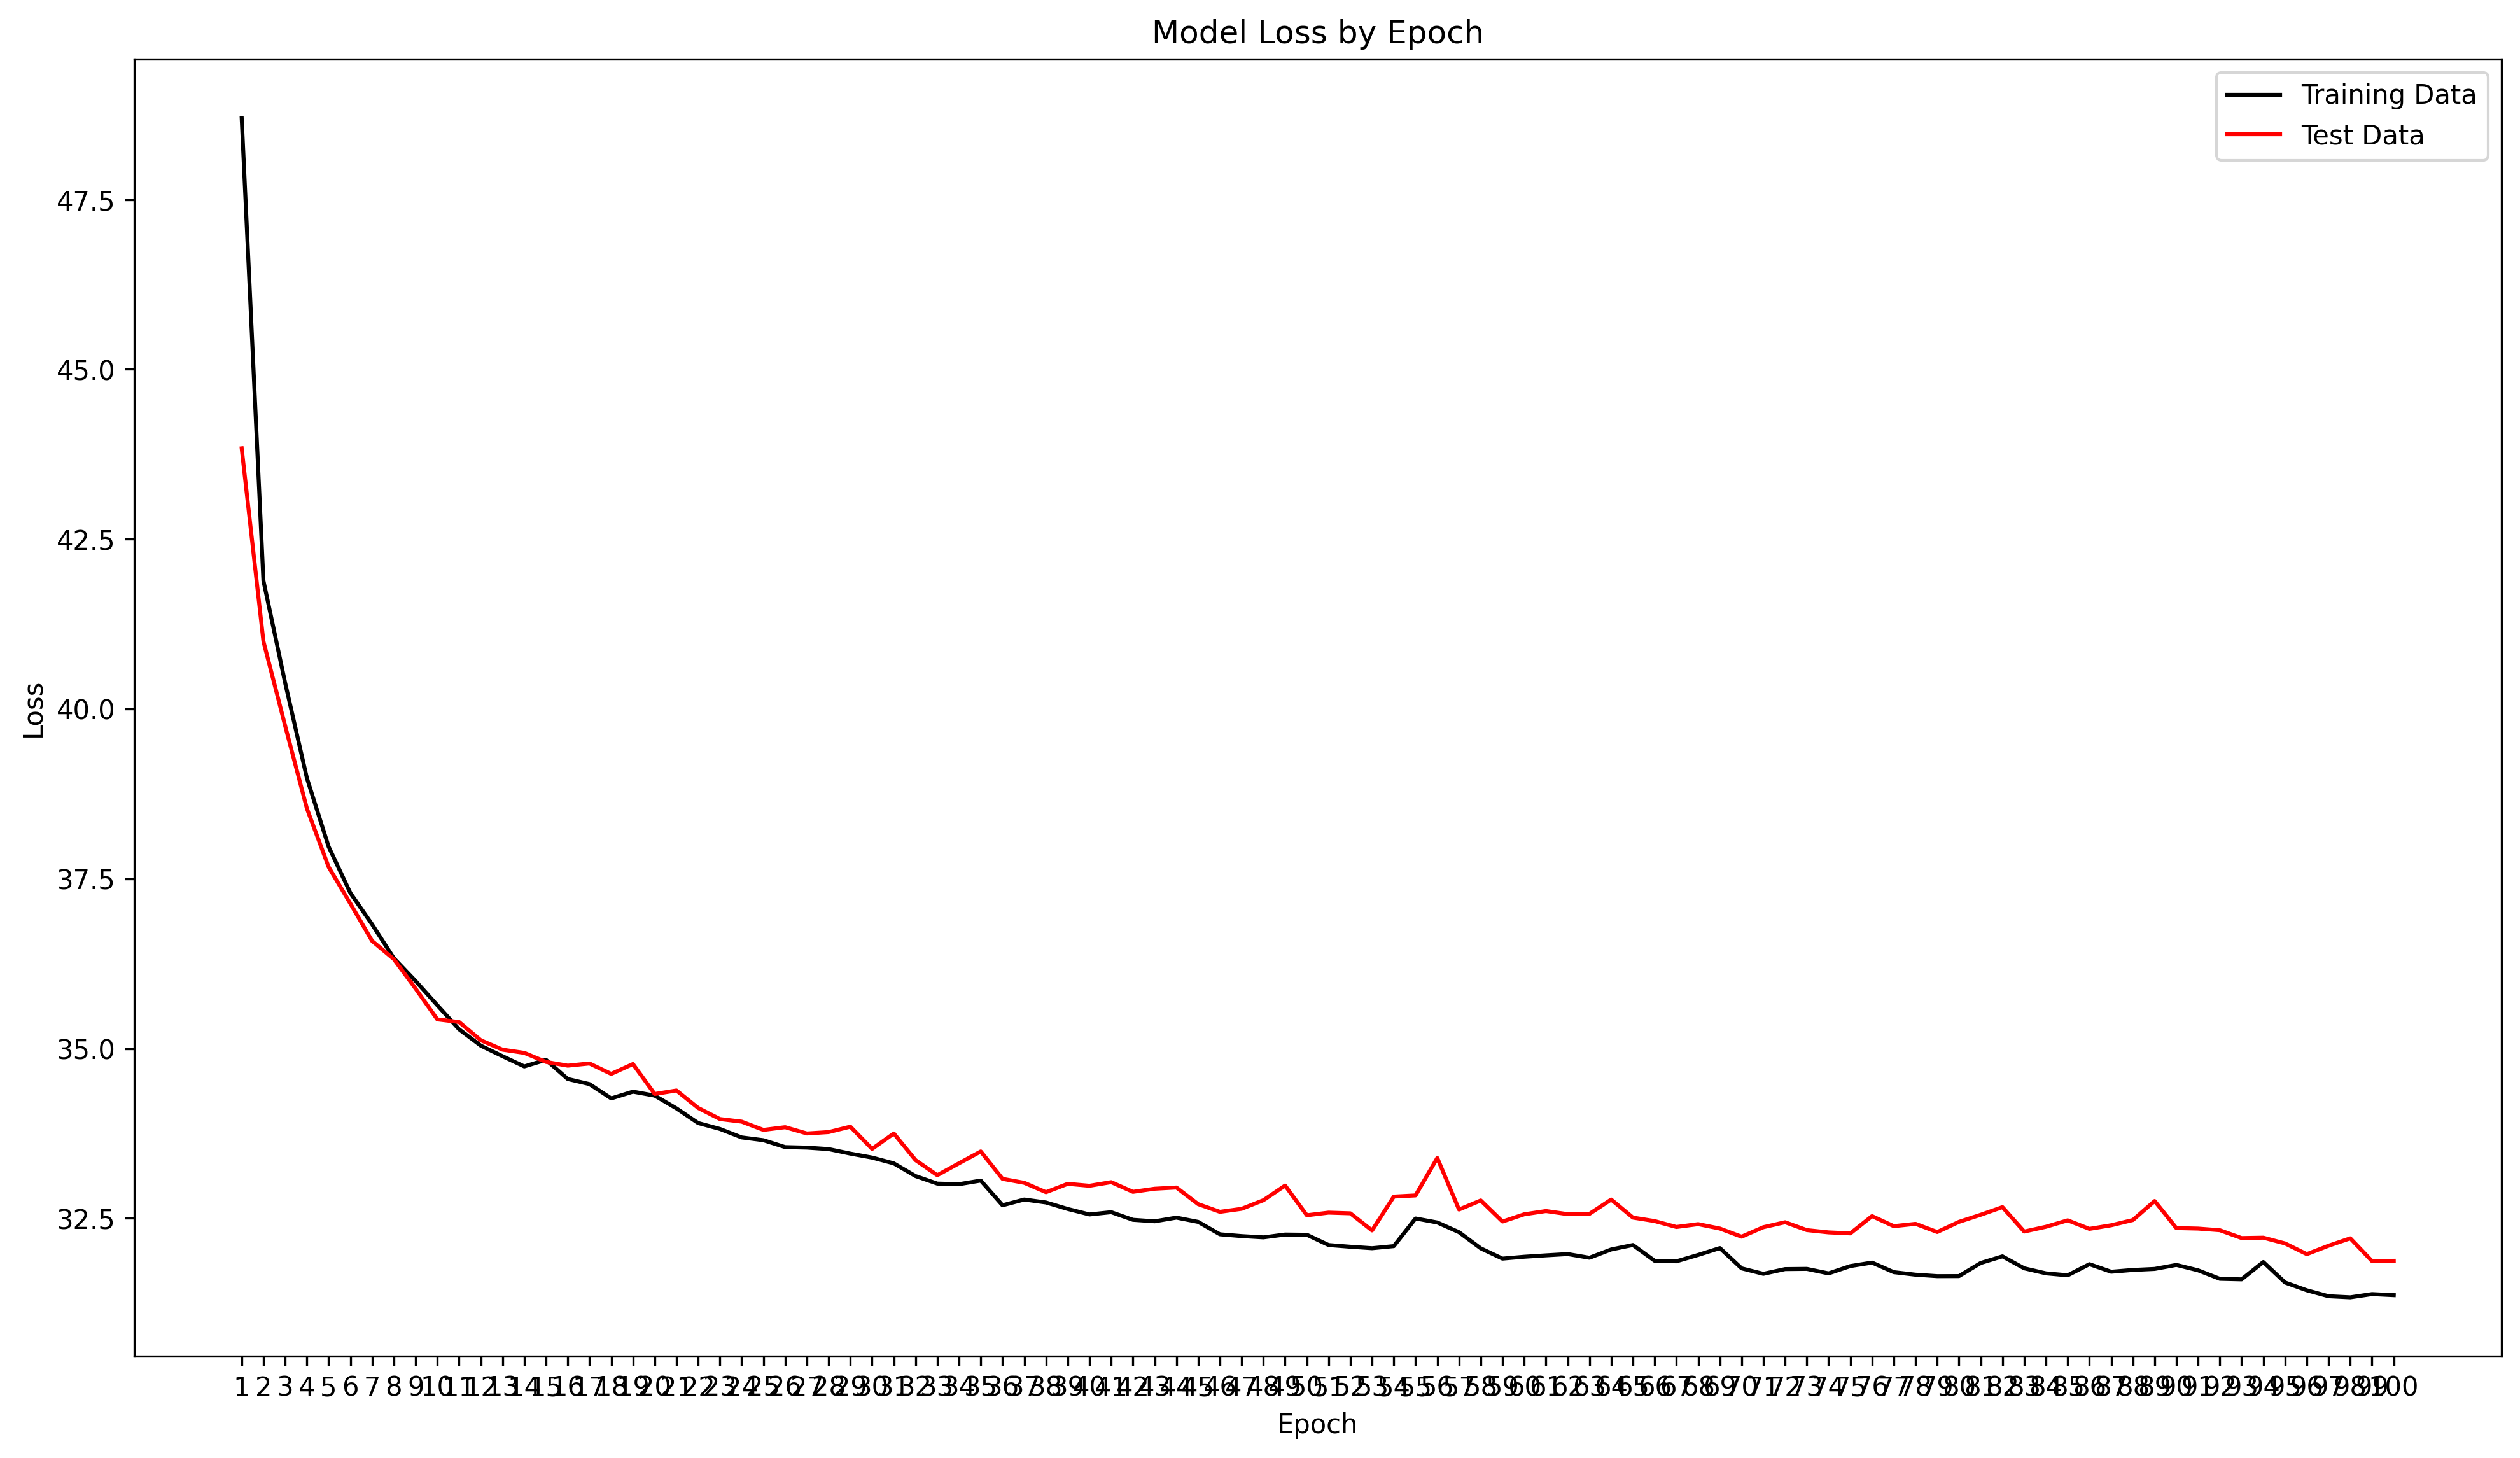

In [ ]:
 # Train VAE model
history = vae.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=(X_test, X_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

**Visualizing Latent Space**

In [ ]:
# Use encoder model to encode inputs into a latent space
X_test_encoded = encoder.predict(X_test)

# Recall that our encoder returns 3 arrays: z-mean, z-log-sigma and z. We plot the values for z
# Create a scatter plot
fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1], 
                 opacity=1, color=y_test.astype(str))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

# Set figure title
fig.update_layout(title_text="MNIST digit representation in the 2D Latent Space")

# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

**Original Digits vs. Reconstructed Digits (VAE)**

In [ ]:
# (x_train_2, y_train_2), _ = keras.datasets.mnist.load_data()              
# x_train_2 = X_train.reshape(60000, 784)

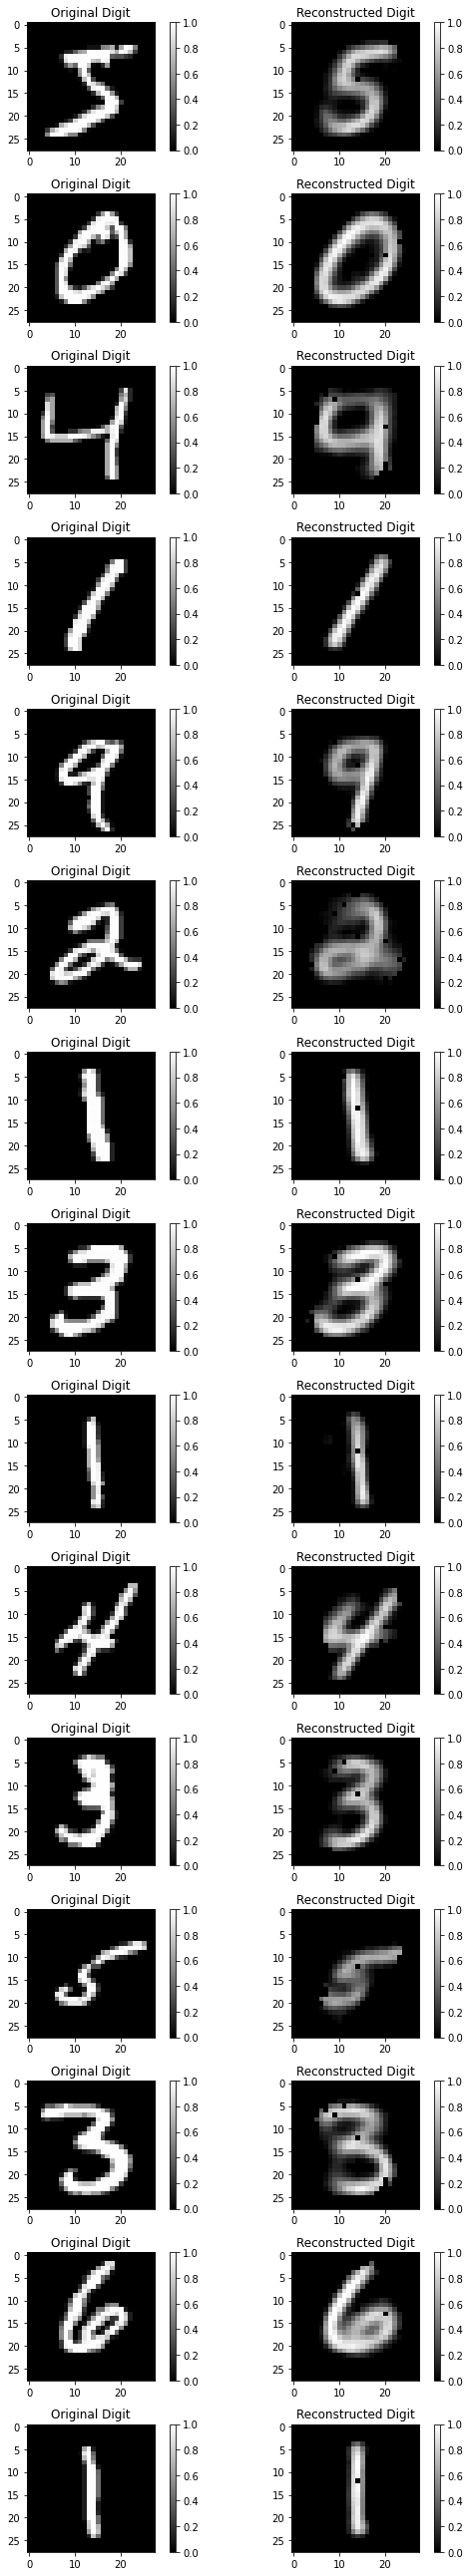

In [ ]:

x_sample = X_train
#print(x_sample.shape)
x_e = encoder.predict(X_train)
#print(x_e[2].shape)
x_d = decoder.predict(x_e[2])
x_reconstruct = x_d

plt.figure(figsize=(8, 36))
for i in range(15):
    plt.subplot(15, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Original Digit")
    plt.colorbar()
    plt.subplot(15, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstructed Digit")
    plt.colorbar()
plt.tight_layout()

**Generate New Digits**

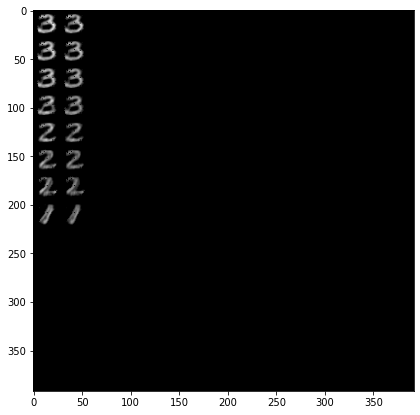

In [ ]:
image_size = 28
values = np.arange(-3, 4, .5)
xx, yy = np.meshgrid(values, values)
input_holder = np.zeros((1, 2))
# Matrix that will contain the grid of images
container = np.zeros((image_size * len(values), image_size * len(values)))


r = 0
c = 0

for row in range(8):
    for col in range(2):
        input_holder = np.array([[xx[row, col], yy[row, col]]])
        output = decoder.predict(input_holder)
        artificial_image = output.reshape((image_size,image_size))
        # container[row * image_size: (row + 1) * image_size, col * image_size: (col + 1) * image_size] = np.squeeze(artificial_image)
        container[row * image_size: (row + 1) * image_size, col * image_size: (col + 1) * image_size] = np.squeeze(artificial_image)
      

plt.figure(figsize=(50,7))
plt.imshow(container, cmap='gray')

**VAE with Latent Space Dim = 32**

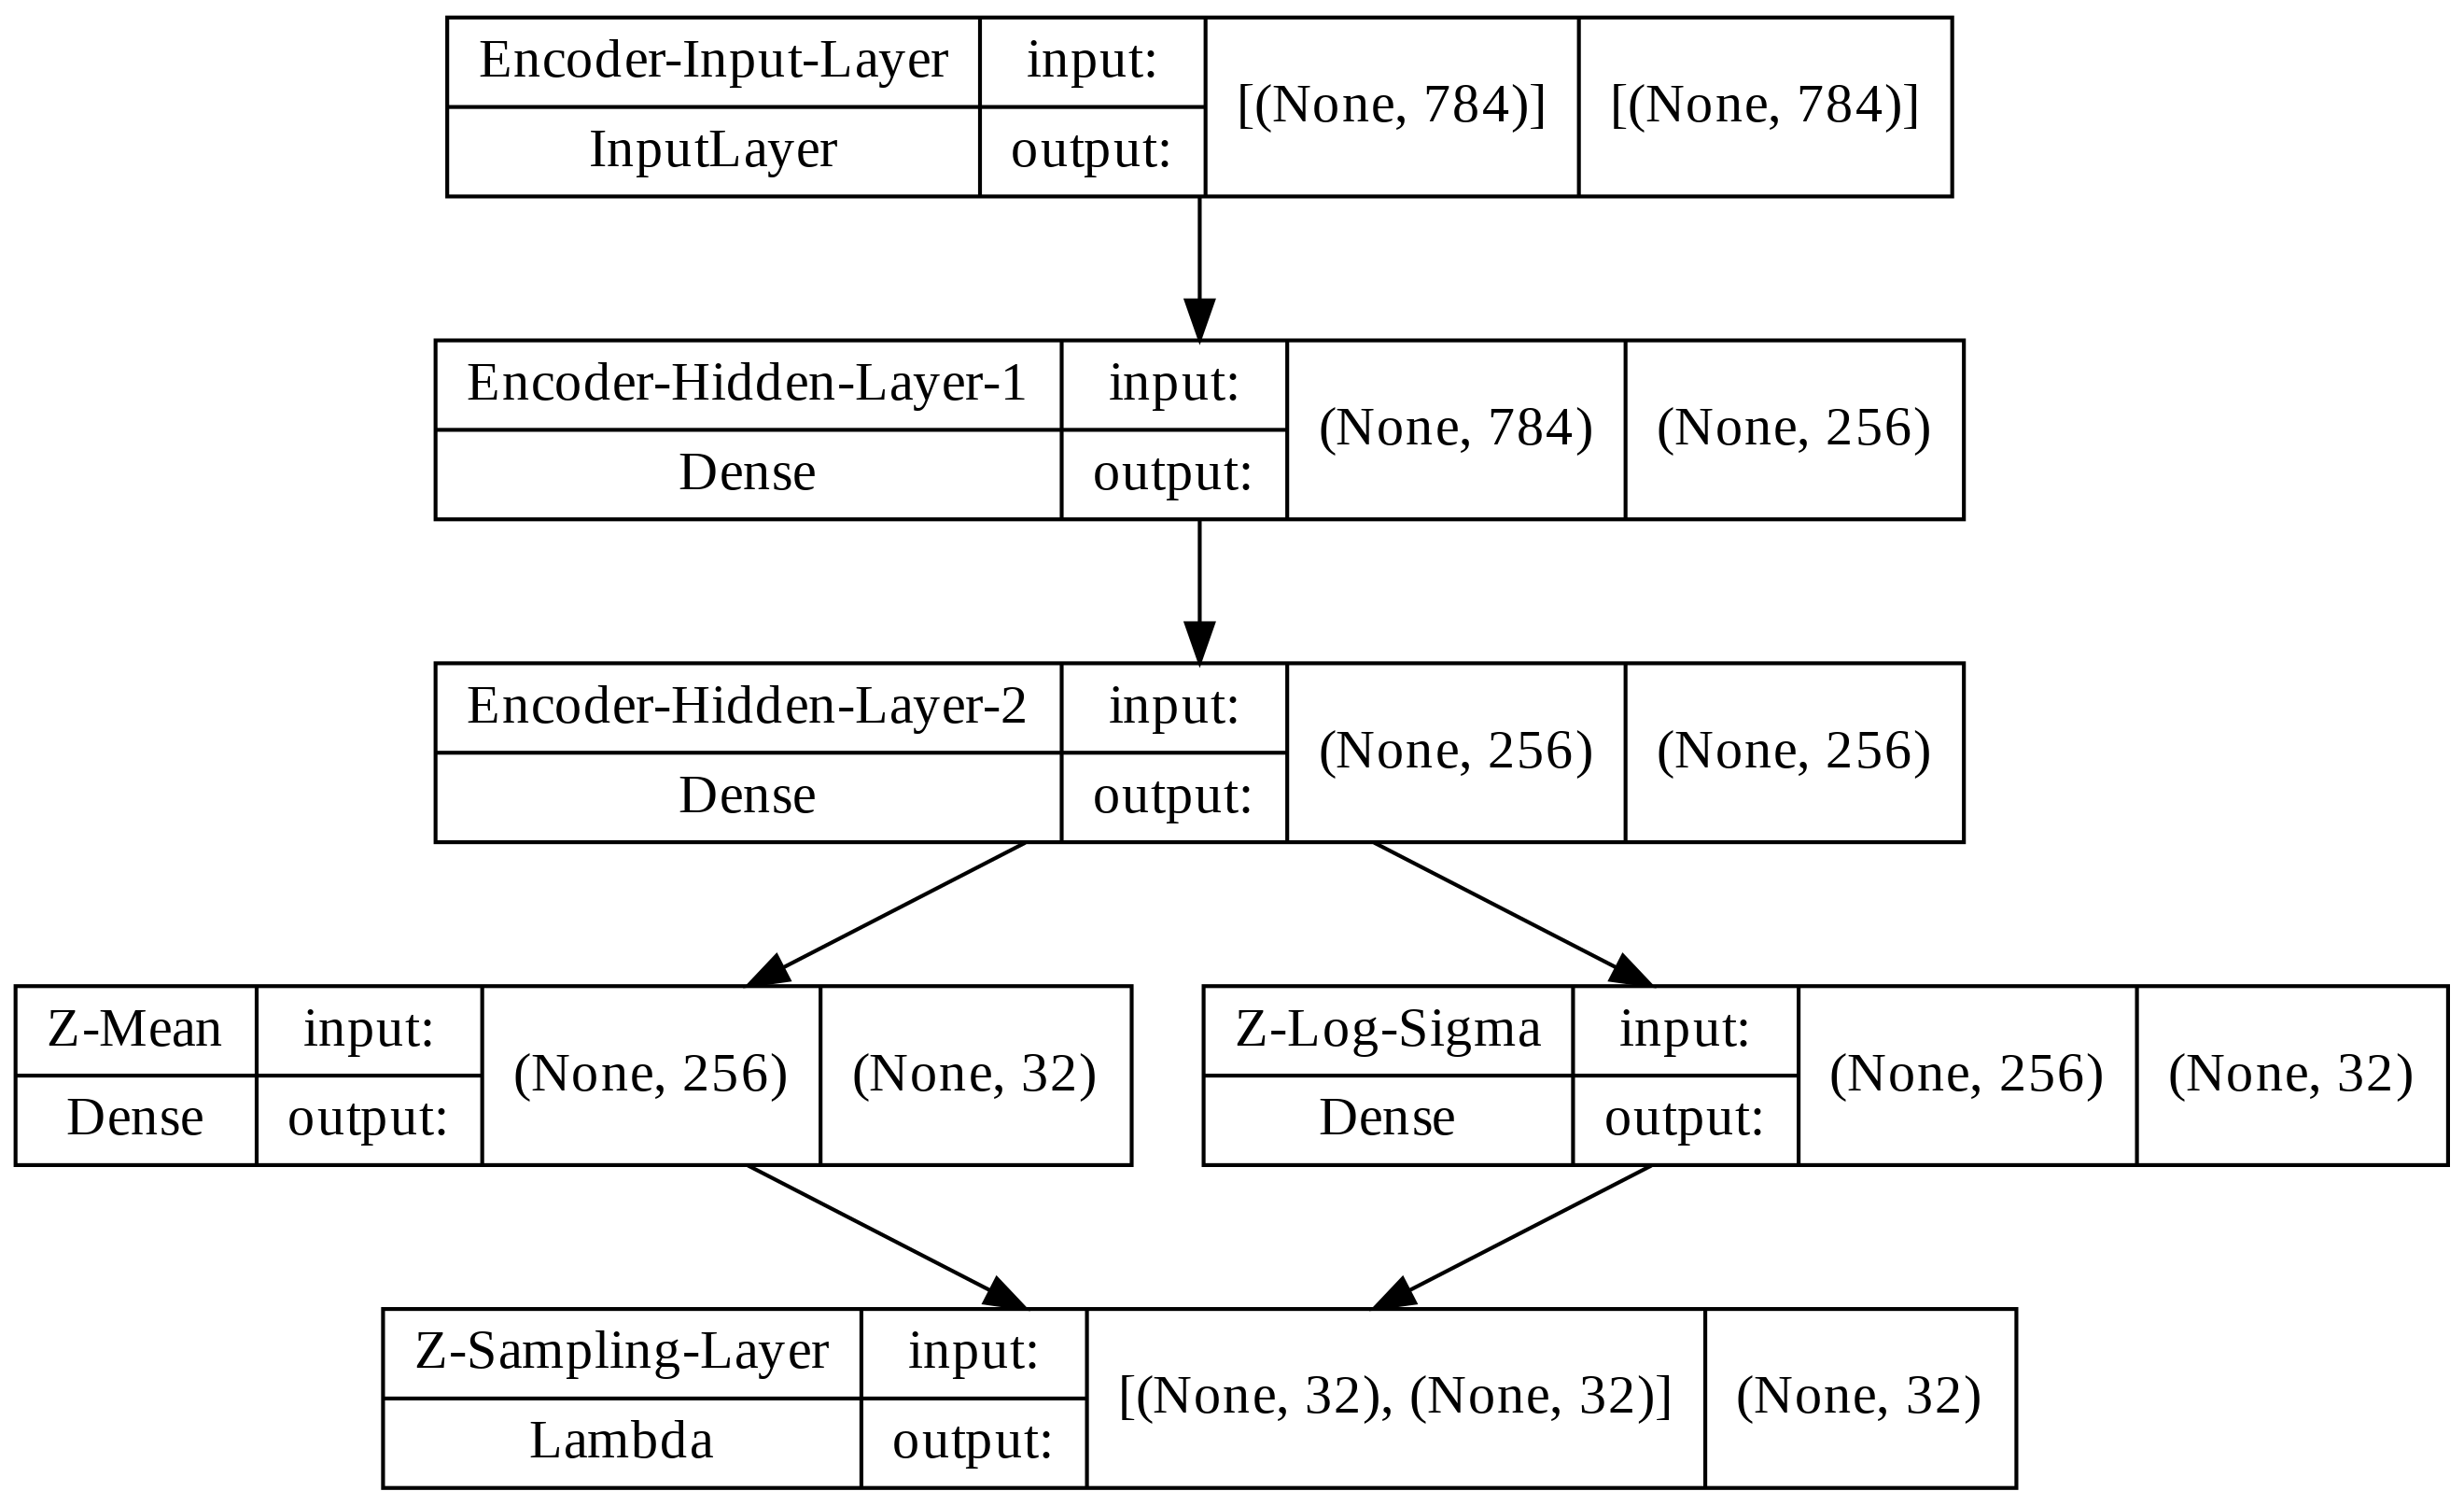

In [ ]:
# Specify dimensions for input/output and latent space layers
original_dim = 784 # number of neurons at the input layer (28 * 28 = 784)
latent_dim = 32 # latent space dimension

# ********** Create Encoder **********

#--- Input Layer 
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

#--- Hidden Layer
h_enc1 = Dense(units=256, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=256, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc2) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc2) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

#--- Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

# Display model diagram
plot_model(encoder, show_shapes=True, dpi=300)

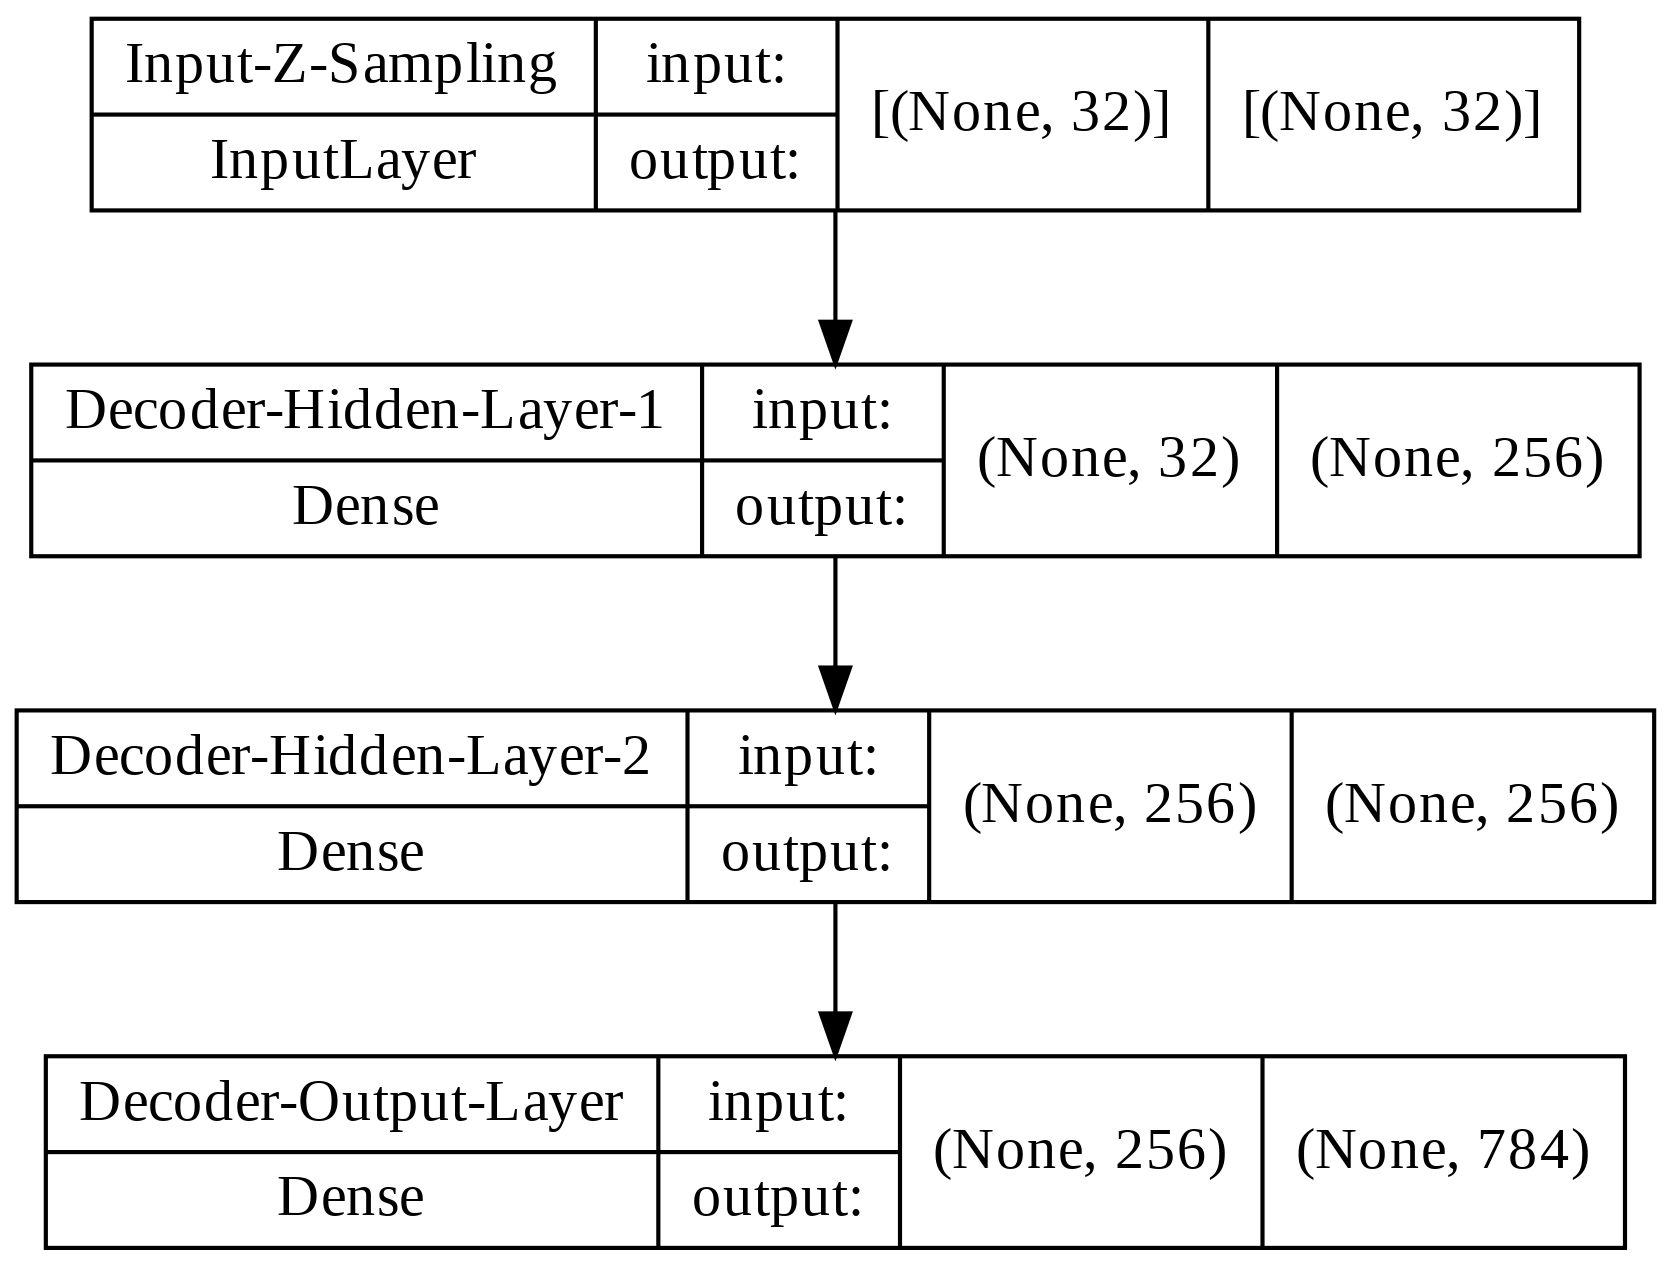

In [ ]:
# ********** Create Decoder **********

#--- Input Layer 
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Hidden Layer
h_dec = Dense(units=256, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=256, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)

#--- Output Layer
outputs = Dense(original_dim, activation='relu', name='Decoder-Output-Layer')(h_dec2)

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

# Display model diagram
plot_model(decoder, show_shapes=True, dpi=300)

In [ ]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae_32 = Model(inputs=visible, outputs=outpt, name='VAE-Model')
vae_32

In [ ]:
# Reconstruction loss compares inputs and outputs and tries to minimise the difference
r_loss = original_dim * keras.losses.mse(visible, outpt)  # use MSE

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add loss to the model and compile it
vae_32.add_loss(vae_loss)
vae_32.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

Epoch 1/50
469/469 [==============================] - 17s 34ms/step - loss: 43.5726 - val_loss: 33.8573
Epoch 2/50
469/469 [==============================] - 11s 24ms/step - loss: 31.2353 - val_loss: 29.2487
Epoch 3/50
469/469 [==============================] - 12s 25ms/step - loss: 28.7367 - val_loss: 27.9002
Epoch 4/50
469/469 [==============================] - 10s 22ms/step - loss: 27.6172 - val_loss: 27.0194
Epoch 5/50
469/469 [==============================] - 11s 23ms/step - loss: 26.8411 - val_loss: 26.3754
Epoch 6/50
469/469 [==============================] - 10s 21ms/step - loss: 26.3011 - val_loss: 26.0287
Epoch 7/50
469/469 [==============================] - 10s 21ms/step - loss: 25.8727 - val_loss: 25.7134
Epoch 8/50
469/469 [==============================] - 10s 21ms/step - loss: 25.5769 - val_loss: 25.3982
Epoch 9/50
469/469 [==============================] - 12s 27ms/step - loss: 25.3090 - val_loss: 25.1211
Epoch 10/50
469/469 [==============================] - 11s 24ms/

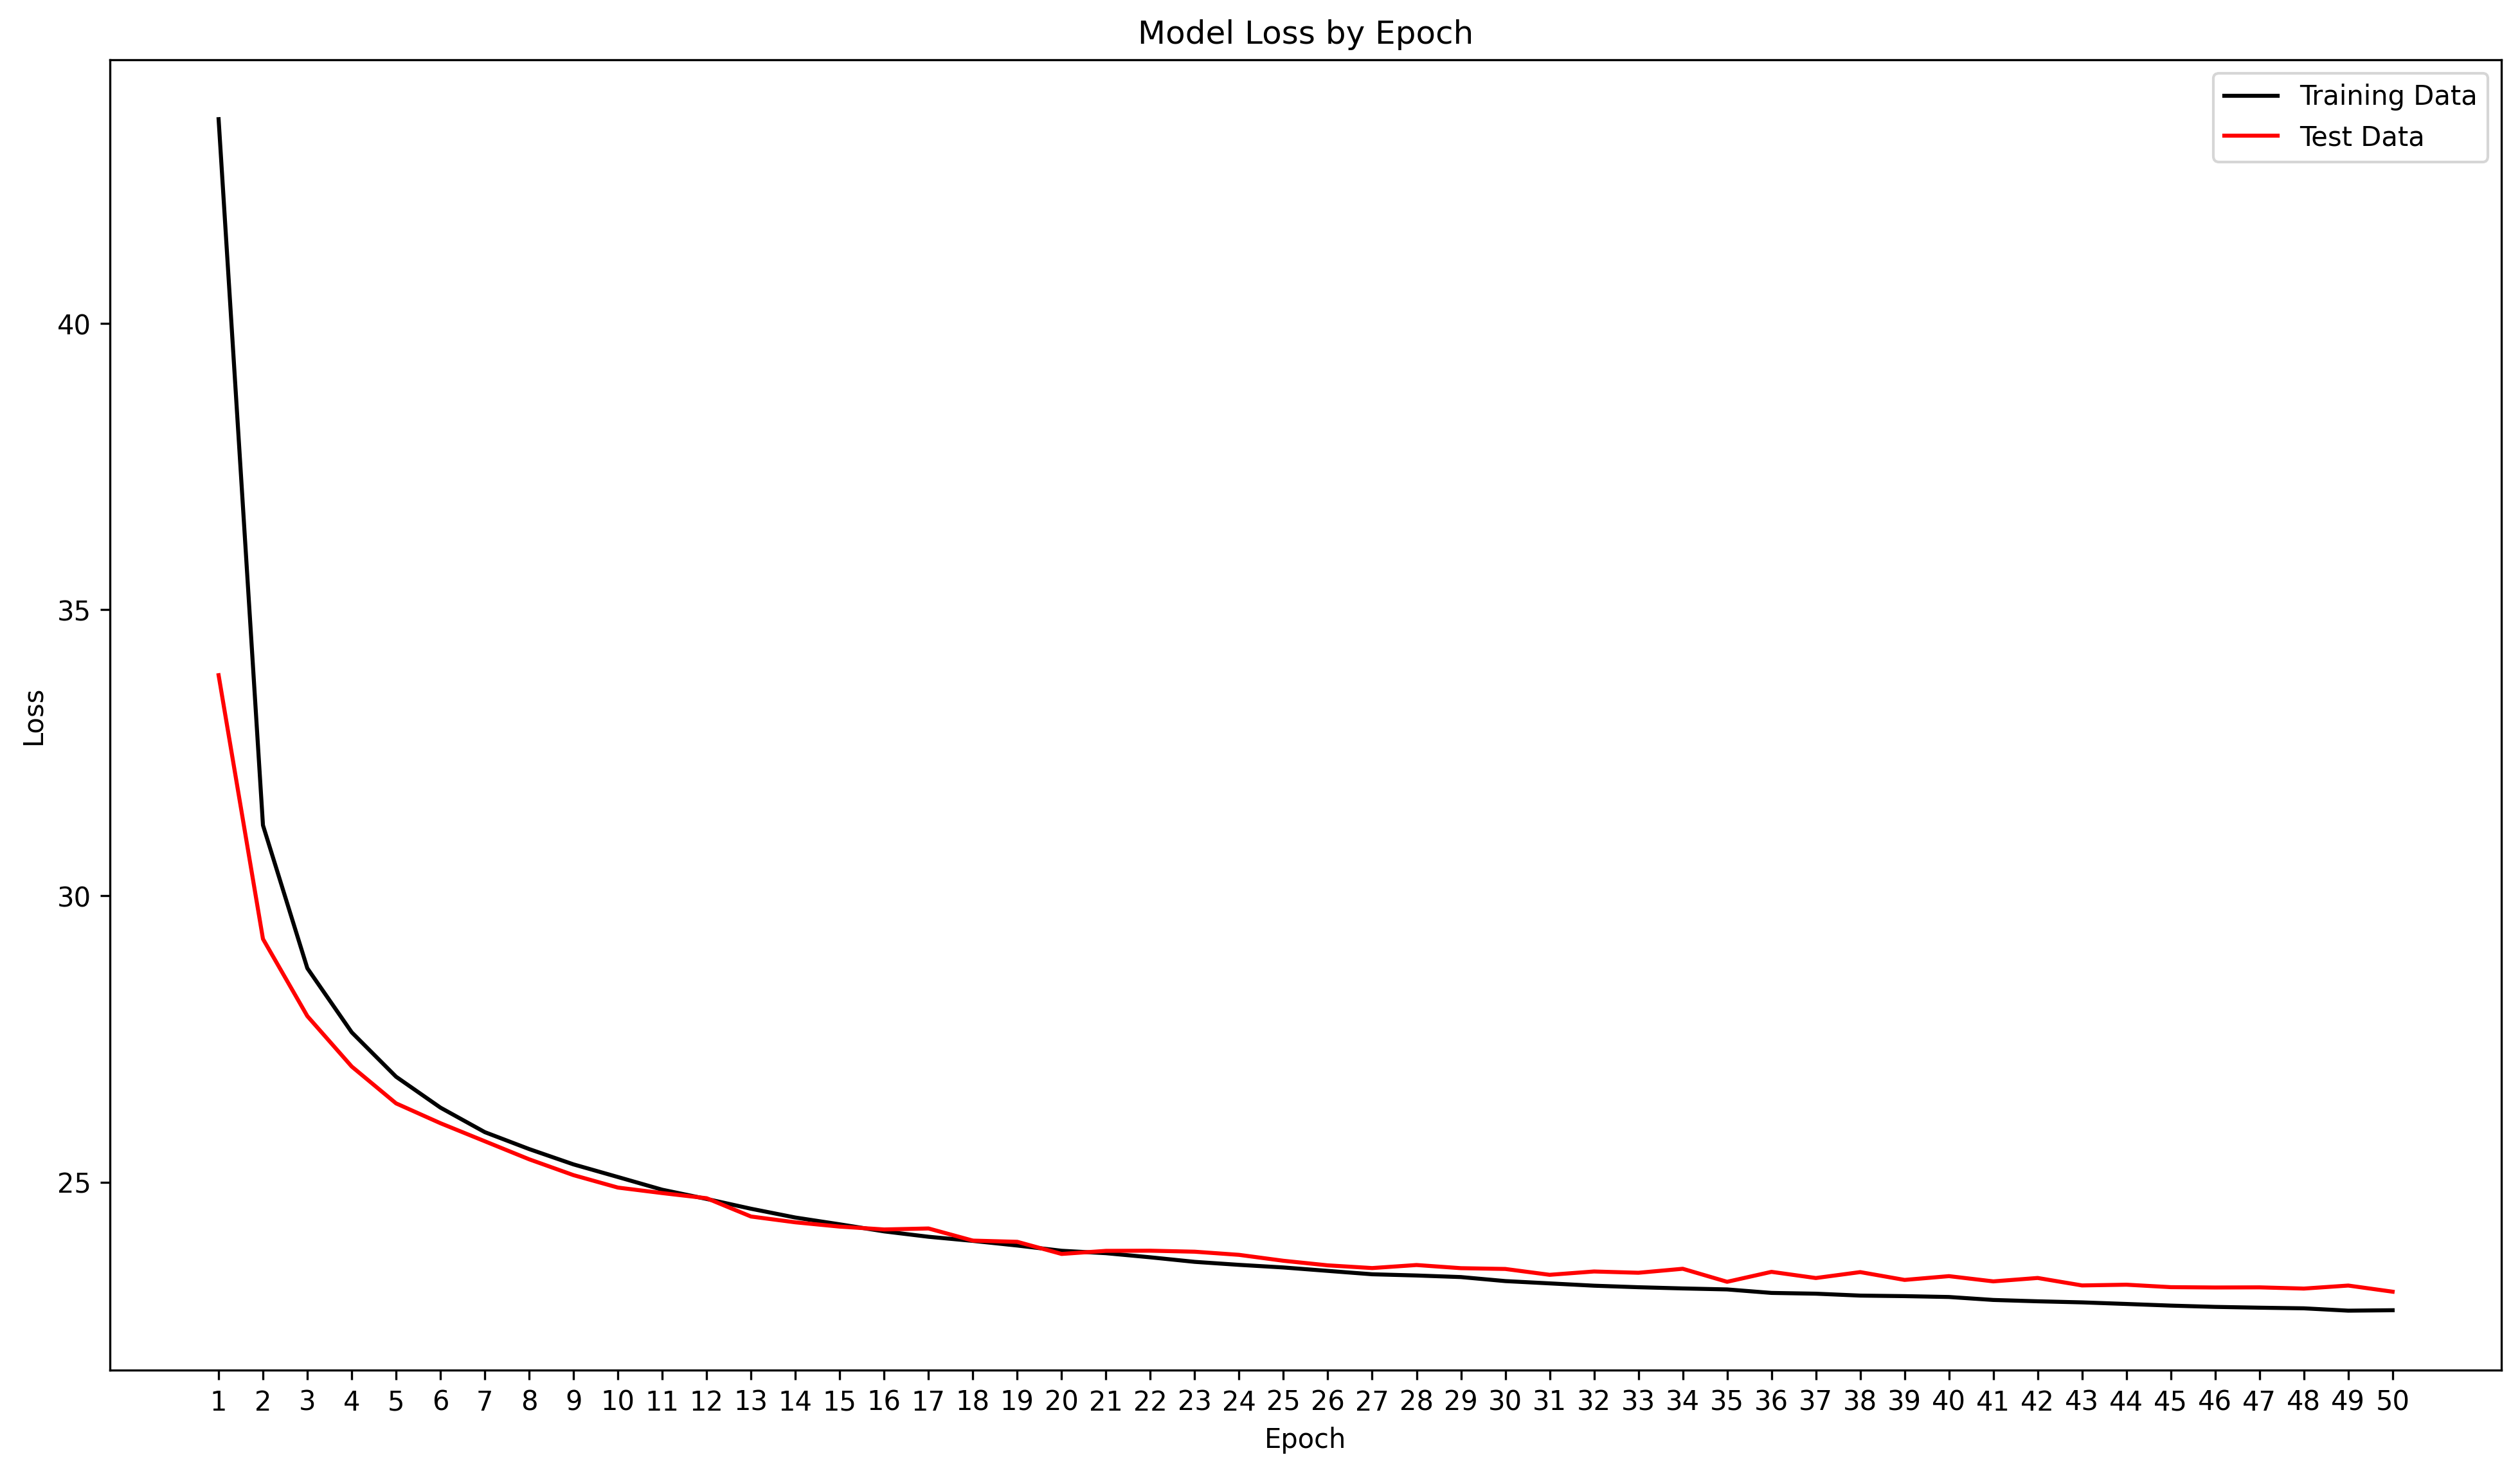

In [ ]:
 # Train VAE model
history = vae_32.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

**Visualizing Latent Space**

In [ ]:
# Use encoder model to encode inputs into a latent space
X_test_encoded = encoder.predict(X_test)

# Recall that our encoder returns 3 arrays: z-mean, z-log-sigma and z. We plot the values for z
# Create a scatter plot
fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1], 
                 opacity=1, color=y_test.astype(str))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

# Set figure title
fig.update_layout(title_text="MNIST digit representation in the 2D Latent Space")

# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

**Original Digits vs. Reconstructed Digits (VAE)**

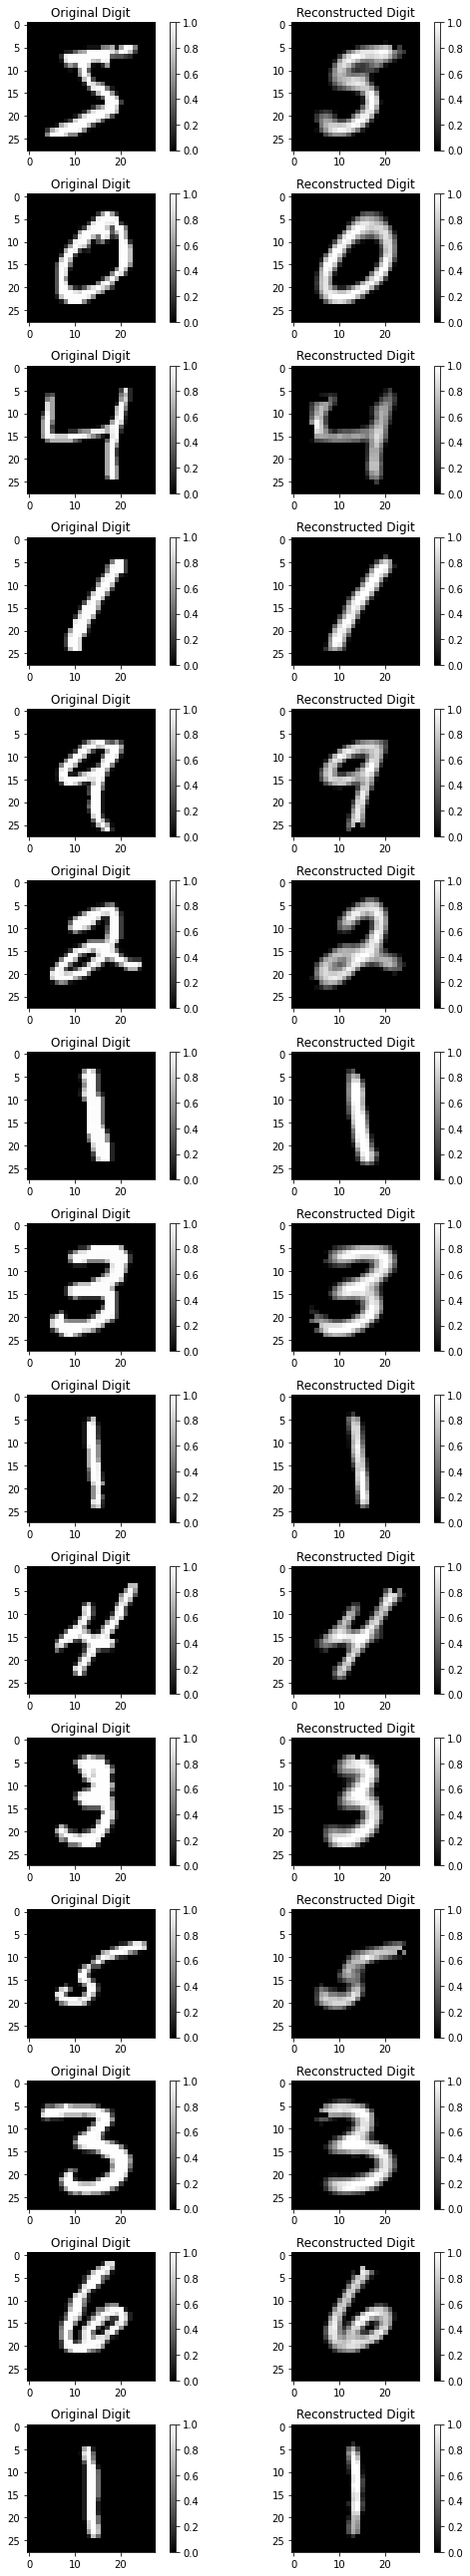

In [ ]:
x_sample = X_train
#print(x_sample.shape)
x_e = encoder.predict(X_train)
#print(x_e[2].shape)
x_d = decoder.predict(x_e[2])
x_reconstruct = x_d

plt.figure(figsize=(8, 36))
for i in range(15):
    plt.subplot(15, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Original Digit")
    plt.colorbar()
    plt.subplot(15, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstructed Digit")
    plt.colorbar()
plt.tight_layout()

**Generate New Digits**

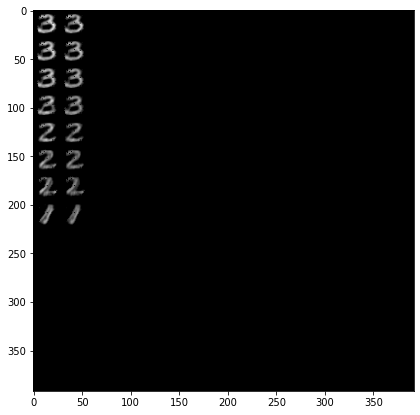

In [ ]:
image_size = 28
values = np.arange(-3, 4, .5)
xx, yy = np.meshgrid(values, values)
input_holder = np.zeros((1, 2))
# Matrix that will contain the grid of images
container = np.zeros((image_size * len(values), image_size * len(values)))


r = 0
c = 0

for row in range(8):
    for col in range(2):
        input_holder = np.array([[xx[row, col], yy[row, col]]])
        output = decoder.predict(input_holder)
        artificial_image = output.reshape((image_size,image_size))
        # container[row * image_size: (row + 1) * image_size, col * image_size: (col + 1) * image_size] = np.squeeze(artificial_image)
        container[row * image_size: (row + 1) * image_size, col * image_size: (col + 1) * image_size] = np.squeeze(artificial_image)
      

plt.figure(figsize=(50,7))
plt.imshow(container, cmap='gray')